In [21]:
#Se cargan las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
##Se lee el archivo y se le asigna la variable df9
df9 = pd.read_csv('vid18_180219.dat', skiprows=1, sep=',',header=None,names=["TIMESTAMP","RECORD","batt_volt_Min","logger_temp","short_up_Avg","short_dn_Avg","long_up_Avg","long_dn_Avg","cnr4_T_C_Avg","cnr4_T_K_Avg","long_up_corr_Avg","long_dn_corr_Avg","Rs_net_Avg","Rl_net_Avg","albedo_Avg","Rn_Avg","AirTC_Avg","RH","WS_ms_S_WVT","WindDir_D1_WVT","WindDir_SD1_WVT","Temp_C_Avg(1)","Temp_C_Avg(2)","Temp_C_Avg(3)","Temp_C_Avg(4)","Result1_Avg","Result2_Avg","Result3_Avg","Result4_Avg","Result5_Avg","Result6_Avg","Result7_Avg","Result8_Avg","Result9_Avg","Riego_mm_Tot","Perco_mm_Tot"])

In [23]:
#Se transforma nuestra columna TIMESTAMP que representa el tiempo en datetime
df9['TIMESTAMP'] = pd.to_datetime(df9.apply(lambda x: x['TIMESTAMP'], 1), dayfirst=True)
df9 = pd.DataFrame(df9)

In [24]:
#Solo nos interesan 2 columnas  TIMESTAMP (Fecha) y  AirTC_Avg (Temperatura del aire, ºC).
df9 = df9[['TIMESTAMP','AirTC_Avg']]
#Creamos una columna para los días, años, meses y horas
df9['MES'] = df9['TIMESTAMP'].dt.month
df9['AÑO'] = df9['TIMESTAMP'].dt.year
df9['DIA'] = df9['TIMESTAMP'].dt.day
df9['HORA'] = df9['TIMESTAMP'].dt.hour

#Sacamos la temperatura media por hora que es con la que vamos a trabajar 
dfmedia = df9.set_index('TIMESTAMP').resample('H').mean()

#Se agarran los valores desde noviembre hasta el ultimo dato
dfmedia = dfmedia.loc['2018-11-01 00:00:00':'2019-02-18 07:30:00']

#Se s aca la necesaria temperatura minima por dia 
dfmedia['TMIN']=dfmedia.groupby(['AÑO','MES','DIA'])['AirTC_Avg'].transform('min')

In [25]:
#Calculamos las HFE
conditions = [
    (dfmedia['AirTC_Avg']<= 10) & (dfmedia['TMIN'] <= 10),
    (dfmedia['AirTC_Avg']>= 25) & (dfmedia['TMIN'] <= 10),
     (dfmedia['TMIN']>=10)]
choices = [1, -1, 0]
dfmedia['HFE'] = np.select(conditions, choices, default=0)


In [26]:
#Ahora se calculas las HFE acumuladas y cambiamos el data frame a puros días 
dfmedia = dfmedia.reset_index()

In [27]:
dfmedia = dfmedia.set_index('TIMESTAMP').resample('D').sum()

In [28]:
dfmedia.drop(['AirTC_Avg','MES','DIA','HORA','TMIN','AÑO'], axis = 1, inplace = True, errors = 'ignore')
dfmedia = dfmedia.reset_index()

In [29]:
dfmedia["HFEA"]=dfmedia["HFE"].cumsum()


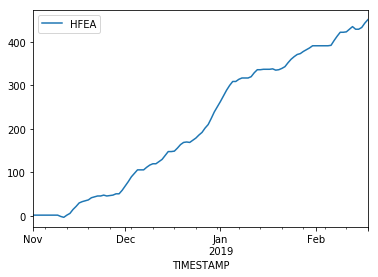

In [30]:
dfmedia.reset_index().plot(x="TIMESTAMP",y=["HFEA"])


In [31]:
#Ahora tendremos 2 columnas de HFEA pero una sera la del modelo de UTAH
#Sacamos la temperatura media por hora que es con la que vamos a trabajar 
dfmediaa = df9.set_index('TIMESTAMP').resample('H').mean()

In [32]:
#Se agarran los valores desde noviembre hasta el ultimo dato
dfmediaa = dfmediaa.loc['2018-11-01 00:00:00':'2019-02-18 07:30:00']


#Establecemos condiciones para los valores de UF
conditions = [
    (dfmediaa['AirTC_Avg'] >= 1.5) & (dfmediaa['AirTC_Avg'] <= 2.4),
    (dfmediaa['AirTC_Avg'] >= 2.5) & (dfmediaa['AirTC_Avg'] <= 9.1),
    (dfmediaa['AirTC_Avg'] >= 9.2) & (dfmediaa['AirTC_Avg'] <= 12.4),
    (dfmediaa['AirTC_Avg'] >= 12.5) & (dfmediaa['AirTC_Avg'] <= 15.9),
    (dfmediaa['AirTC_Avg'] >= 16) & (dfmediaa['AirTC_Avg'] <=18),
    (dfmediaa['AirTC_Avg'] > 18 )]

choices = [0.5, 1.0, 0.5, 0, -0.5, -1.0]
#LE damos los valores a UF
dfmediaa['UF'] = np.select(conditions, choices, default=0)

#Se calcula UF24
dfmediaa['UF24'] = dfmediaa.groupby(['AÑO','MES','DIA'])['UF'].transform('sum')

#Se crea una tabla df10 con la suma por hora
df10 = dfmediaa[['AirTC_Avg']]
df10 = df10.resample('D').sum()


#Se le asigna el valor de la suma a una nueva columna UF24
df10 ['UF'] = dfmediaa['UF24']

#Se crea un nuevo data frame con la media por dìa, si lel valor se mantiene igual todo el dìa no tiene que cambiar
dfdia = dfmediaa.resample('D').mean()

In [36]:
dfdia.drop(['AirTC_Avg','MES','DIA','HORA','AÑO', 'UF'], axis = 1, inplace = True, errors = 'ignore')

In [51]:
dfdia['UFA'] = dfdia['UF24'].cumsum()
dfmedia['UFA'] = dfdia['UFA']



In [50]:
dfdia = dfdia.reset_index()

In [53]:
dfmedia.head()

,TIMESTAMP,HFE,HFEA,UFA
0,2018-11-01,2,2,-0.5
1,2018-11-02,0,2,-9.5
2,2018-11-03,0,2,-19.0
3,2018-11-04,0,2,-30.5
4,2018-11-05,0,2,-38.5
